# Feature exploration 
- seizure in the most represented case

In [11]:
import os
from typing import Optional, Union
import numpy as np
from enum import Enum
import pandas as pd 
from matplotlib import pyplot as plt


## Preamble

In [13]:
from source.preamble import *

train_eeg_names = os.listdir(Dir.eeg_train)
train_spc_names = os.listdir(Dir.spc_train)
len(train_eeg_names), len(train_spc_names)

(17300, 11138)

## Functions definition

In [14]:
class Sample:

    def __init__(
            self, 
            eeg_id:int,
            spc_id:int,
            eeg_subsample:int,
            patient_id:int
            ):
        self.eeg_id = eeg_id

    def get_eeg():
        NotImplemented

    def get_spc():
        NotImplemented


In [15]:
def open_train_metadata(folder:str) -> pd.DataFrame:
    """
    open and process train.csv file
    """
    train = pd.read_csv(os.path.join(Dir.root, "train.csv"))
    vote_cols = [c for c in train.columns if c.endswith("vote")]
    train["n_votes"] = train[vote_cols].sum(axis=1)
    for c in vote_cols:
        train[c] = train[c] / train["n_votes"]
    train["eeg_length"] = train.groupby("eeg_id")["eeg_label_offset_seconds"].diff().shift(-1).fillna(-1).astype(int)
    return train

def open_file_id(folder:str, id:Union[str, int], prefix:str="", extension:str=".parquet") -> pd.DataFrame:
    return pd.read_parquet(os.path.join(folder, prefix + str(id) + extension))

def get_eeg_sample(id:int, subid:int, offset:int, length:int) -> pd.DataFrame:
    eeg_samp = open_file_id(Dir.eeg_train, id)
    start, end = offset * Const.fq_eeg, (offset + length) * Const.fq_eeg
    return eeg_samp.iloc[start:end]

def get_eeg_subsample(full_eeg:pd.DataFrame, start:int, end:int) -> pd.DataFrame:
    return full_eeg.iloc[start: end]

## Metadata

In [16]:
train = open_train_metadata(Dir.root)
CLASSES = train["expert_consensus"].unique()
EEG_IDS = train["eeg_id"].unique()

In [17]:
train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,n_votes,eeg_length
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3,6
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3,2
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3,10
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3,6
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,1.0,0.0,0.0,0.0,0.0,0.0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0,3,2
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0,3,2
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0,3,2
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0.0,0.0,0.0,1.0,0.0,0.0,3,2


### EEG classifiction length

min        2.0
max       48.0
median     4.0
Name: eeg_length, dtype: float64

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])

<Axes: ylabel='Frequency'>

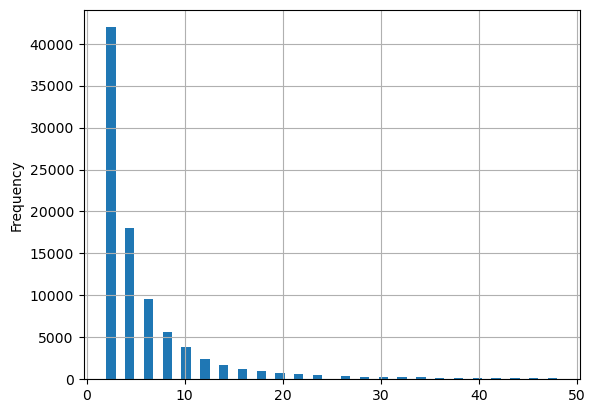

In [18]:
eeg_length = train.loc[train["eeg_length"] > 0]["eeg_length"]
display(eeg_length.agg(["min", "max", "median"]))
display(eeg_length.sort_values().unique())
eeg_length.plot(kind="hist", grid=True, bins=48)

### Classes imbalance

<Axes: xlabel='expert_consensus'>

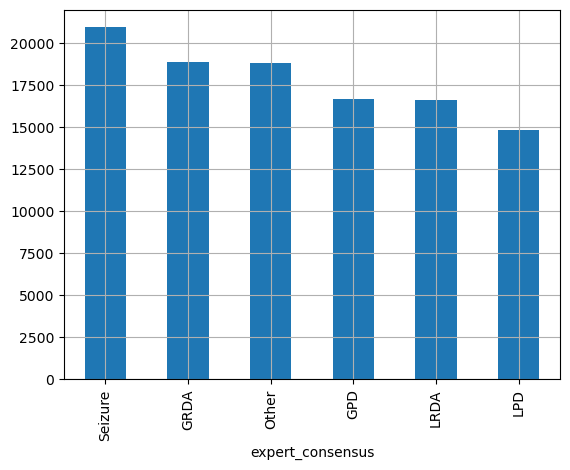

In [8]:
train["expert_consensus"].value_counts().plot(kind="bar", grid=True)

## EEG

### Repartition of different classes

<Axes: xlabel='expert_consensus'>

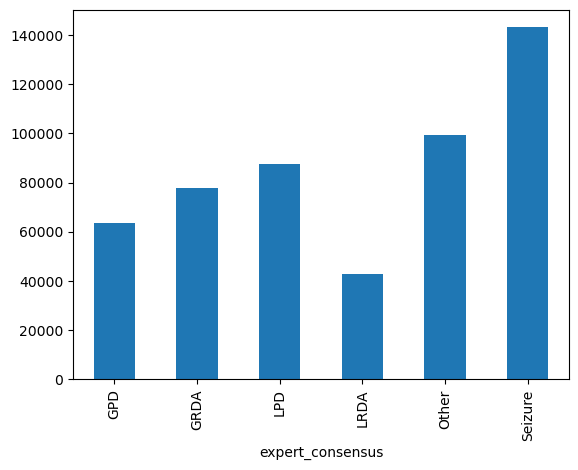

In [9]:
train.loc[train["eeg_length"] > 0].groupby("expert_consensus")["eeg_length"].sum().plot(kind="bar")

### Signal observation
- EEG signals are split into subsamples of different lenghts that are classified (not necessarily different label for two consecutive samples)


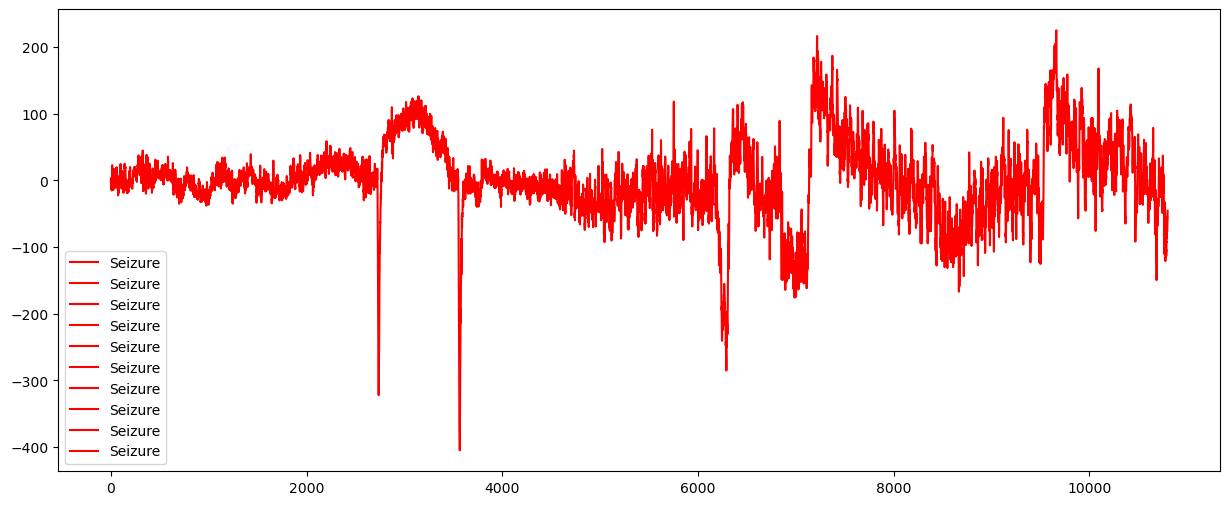

In [10]:
eeg_id = train["eeg_id"][250]
train_eeg = train.loc[train["eeg_id"] == eeg_id].reset_index()
eeg_full = open_file_id(Dir.eeg_train, eeg_id)
SIGNAL_NAMES = eeg_full.columns

fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(train_eeg)):
    offset = int(train_eeg.loc[i, "eeg_label_offset_seconds"])
    cls = train_eeg.loc[i, "expert_consensus"]
    length = int(train_eeg.loc[i, "eeg_length"])
    if length > 0 :
        start, end = offset * 200, offset * 200 + length * 200
        eeg = get_eeg_subsample(eeg_full, start, end)
        eeg["Fp1"].plot(ax=ax, c=COLOR_MAP[cls], label=str(cls))

ax.legend()

### Get first and second moment for each category for each signal
- Would it be a good starting feature for a linear model ?

Steps :
- estimate the mean and order two moment (as empirical average) for each class 
- use empirical variance of samples (or quantiles) to assess separability power of both features

#### Get confidence interval on each 
- by assuming gaussian distribution 
- by bootstrap sampling -> usefull for small datasets
cls_idx, sn_idx = 2, 5
pd.Series(m1sd[CLASSES[cls_idx]][SIGNAL_NAMES[sn_idx]]).plot(kind="hist", bins=50, logy=True)
> None of the distributions appear to be gaussian

In [11]:
m1s = pd.DataFrame(index=CLASSES, columns=SIGNAL_NAMES)
m2s = pd.DataFrame(index=CLASSES, columns=SIGNAL_NAMES)
m1_emp_vars = pd.DataFrame(index=CLASSES, columns=SIGNAL_NAMES)
m2_emp_vars = pd.DataFrame(index=CLASSES, columns=SIGNAL_NAMES)

# store empirical values for all eegs to get confidence intervals => separability
m1sd = { cls: {n: [] for n in SIGNAL_NAMES} for cls in CLASSES}
m2sd = { cls: {n: [] for n in SIGNAL_NAMES} for cls in CLASSES}

In [12]:
# as a list of values -> KNN possible then ? check separability
for eeg_id in EEG_IDS:
    train_eeg = train.loc[train["eeg_id"] == eeg_id].reset_index()
    eeg_full = open_file_id(Dir.eeg_train, eeg_id)
    for i in range(len(train_eeg)):
        offset = int(train_eeg.loc[i, "eeg_label_offset_seconds"])
        cls = train_eeg.loc[i, "expert_consensus"]
        length = int(train_eeg.loc[i, "eeg_length"])
        if length > 0 :
            start, end = offset * Const.fq_eeg, (offset+ length) * Const.fq_eeg
            eeg = get_eeg_subsample(eeg_full, start, end)
            for sn in SIGNAL_NAMES:
                clean_eeg = pd.Series(m1sd["Seizure"]["Fp1"]).dropna().mean()
                m1sd[cls][sn].append(np.mean(pd.Series(eeg[sn]).dropna()))
                m2sd[cls][sn].append(np.mean(pd.Series(eeg[sn]**2).dropna()))


KeyboardInterrupt: 

In [ ]:
for cls in CLASSES:
    for sn in SIGNAL_NAMES:
        m1s.loc[cls, sn] = np.mean(pd.Series(m1sd[cls][sn]).dropna())
        m2s.loc[cls, sn] = np.mean(pd.Series(m2sd[cls][sn]).dropna())

        m1_emp_vars.loc[cls, sn] = np.abs(np.mean(np.quantile(pd.Series(m1sd[cls][sn]).dropna(), [.25, .75])))
        m2_emp_vars.loc[cls, sn] = np.abs(np.mean(np.quantile(pd.Series(m2sd[cls][sn]).dropna(), [.25, .75])))

In [ ]:
m1s.to_csv(os.path.join(base_dir, "intermediate_output", "m1_eeg.csv"))
m2s.to_csv(os.path.join(base_dir, "intermediate_output", "m2_eeg.csv"))
m1_emp_vars.to_csv(os.path.join(base_dir, "intermediate_output", "m1_eeg_emp_var.csv"))
m2_emp_vars.to_csv(os.path.join(base_dir, "intermediate_output", "m2_eeg_emp_var.csv"))

Text(0.5, 1.0, 'Average signal means by category')

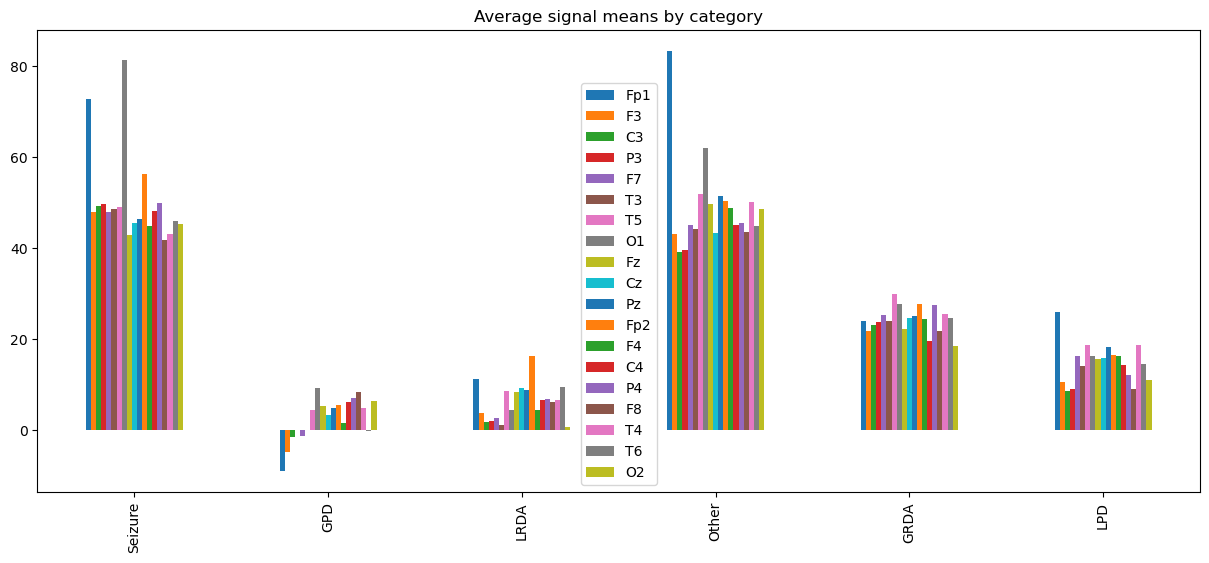

In [ ]:
ax = m1s.drop(columns="EKG").plot(kind="bar", figsize=(15,6))
ax.set_title("Average signal means by category")

Text(0.5, 1.0, 'Average signal power (second moment) by category')

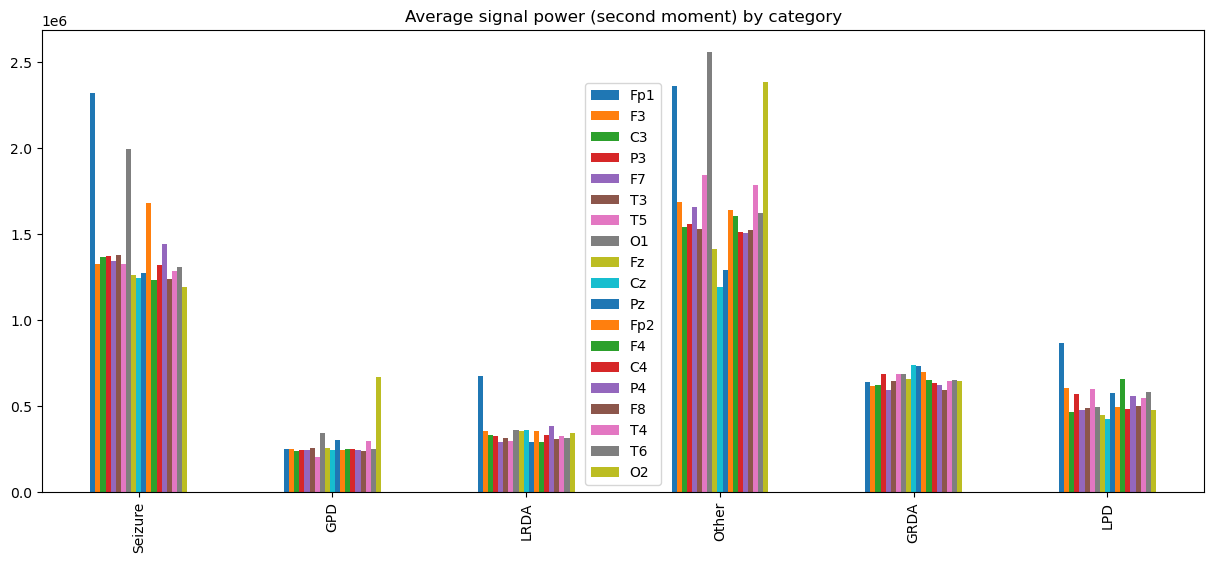

In [ ]:
ax = m2s.drop(columns="EKG").plot(kind="bar", figsize=(15,6))
ax.set_title("Average signal power (second moment) by category")

In [ ]:
m2s

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
Seizure,2325144.326364,1326085.756317,1365427.66686,1375674.208621,1342174.988363,1378000.583947,1327965.485979,1993824.922477,1262079.883862,1244177.468926,1273531.415886,1683673.785051,1232400.87332,1320981.474768,1442343.488696,1239005.8653,1288967.367192,1310074.719981,1192929.972438,8203485.649686
GPD,249885.711495,247977.883419,240239.051626,241933.546547,241699.64259,258230.146138,201930.125416,344468.191577,259058.952408,244861.700516,302147.725766,244481.43799,248374.829634,248579.302181,247204.729593,239843.320551,298414.276697,252107.739851,671050.958627,3382019.130141
LRDA,677334.589508,353129.201294,331828.537461,326734.040242,293844.773937,315003.480483,295282.395413,363479.76081,354883.158283,361618.875994,289808.64699,355343.154317,290167.735013,332738.390724,384294.544271,309853.793073,326014.71207,314231.18434,345522.041338,2146465641.979445
Other,2361663.801852,1687909.870611,1542358.78862,1558790.201466,1660663.176569,1529554.288425,1847798.418596,2560715.042673,1415526.830319,1194570.391623,1290552.39454,1640327.781461,1605323.315235,1512799.727965,1506443.497032,1525707.685383,1789678.251919,1626718.382455,2386574.917694,2788306907.945763
GRDA,639127.527673,618233.353968,622729.475589,685142.409451,596304.214729,646587.578176,688417.787821,686728.985339,658247.195954,738785.428082,734879.148367,700144.914248,649862.438193,633344.131417,625073.239303,593004.322988,644974.376431,653464.898532,646122.168748,2786398.345724
LPD,866463.910795,604453.324443,467943.384569,568503.748809,474838.935826,487288.787671,599608.731024,494059.711843,449101.436516,426344.603344,575640.644218,492807.653629,659697.387988,485325.676336,561753.019129,499765.673537,547463.514534,579424.282418,477884.809268,3257014744.507366


Text(0.5, 1.0, 'EEG means with centered 50% quantile span')

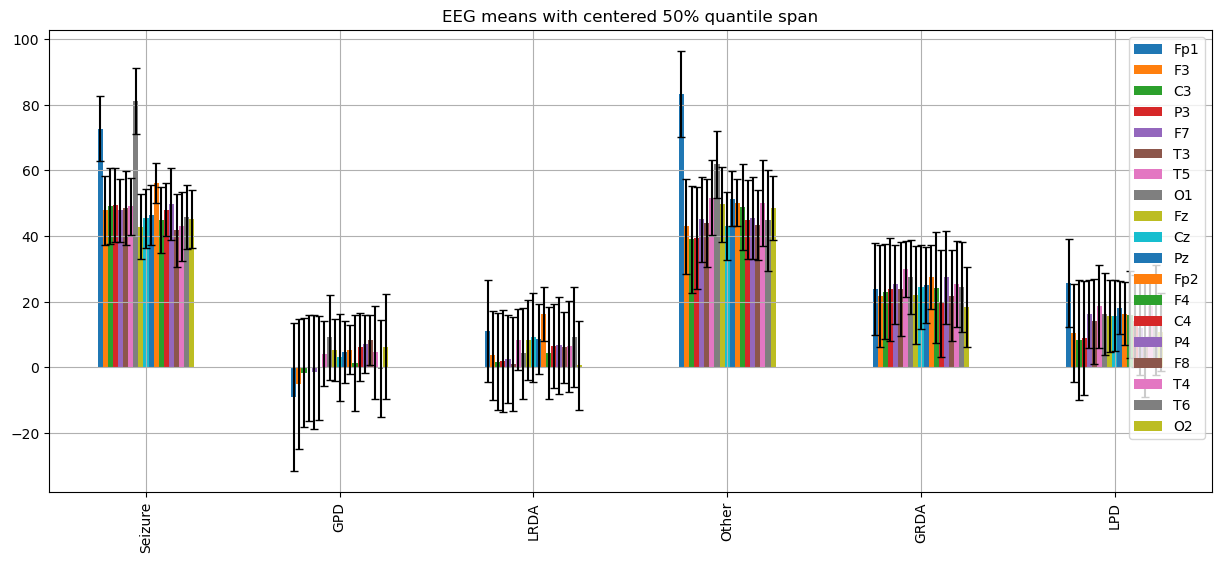

In [ ]:
ax = m1s.drop(columns="EKG").plot(kind="bar", figsize=(15,6), yerr=m1_emp_vars.drop(columns="EKG"), capsize=3, grid=True)
ax.set_title("EEG means with centered 50% quantile span")

Text(0.5, 1.0, 'EEG means with centered 50% quantile span')

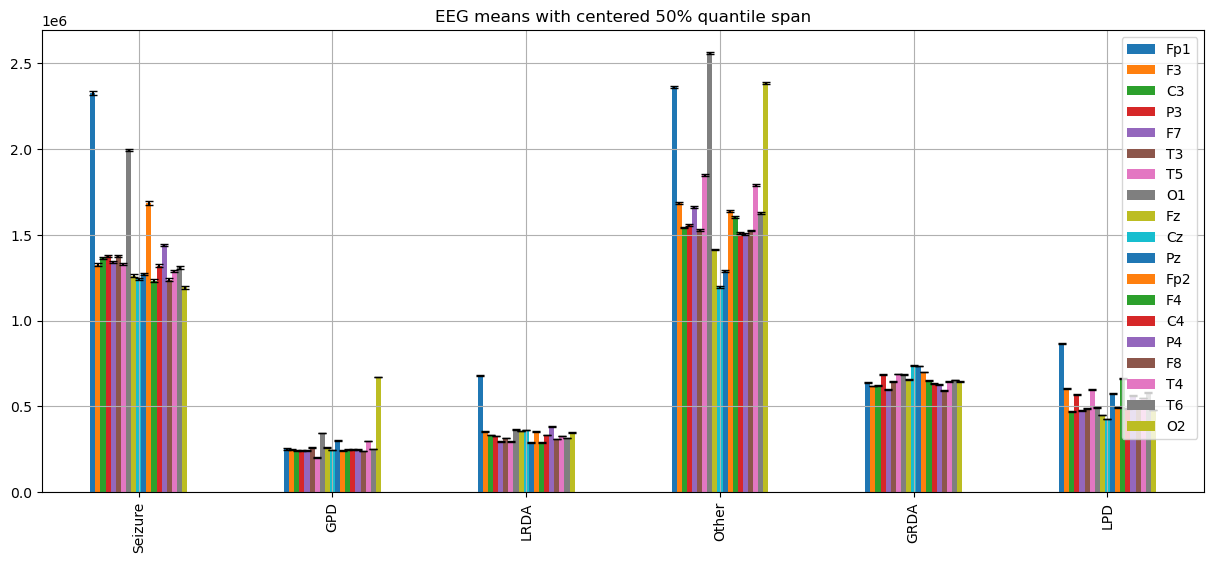

In [ ]:
ax = m2s.drop(columns="EKG").plot(kind="bar", figsize=(15,6), yerr=m2_emp_vars.drop(columns="EKG"), capsize=3, grid=True)
ax.set_title("EEG means with centered 50% quantile span")

First moment seems to have very poor predicting power, the second moment seems to be better.


In [ ]:
pd.read_csv(os.path.join(base_dir, "intermediate_output", "m2_eeg_emp_var.csv"))

,Unnamed: 0,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,...,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,Seizure,12015.802719,7351.391846,6667.373360,6412.977951,7285.347870,5669.042969,6164.779526,6683.842308,7280.835281,...,5937.878265,11657.729309,7820.965973,6695.039612,6494.086365,7718.336090,6096.226944,6758.101028,6080.631714,39093.864197
1,GPD,4076.615356,3073.067123,2621.445129,2048.457680,2502.591141,1837.637383,1761.694283,1544.078880,3098.271942,...,3247.752777,3234.775177,2703.357117,2059.292664,2439.890305,2258.879959,1738.042915,1556.722603,2062.592705,11648.283213
2,LRDA,2836.259338,2173.847900,1885.892212,1729.508835,2273.177948,1996.426407,1704.225723,1863.021698,1805.737762,...,1376.579468,2385.897858,2153.242218,1849.647812,2194.987518,2249.135818,2063.159912,1823.792938,2162.076843,18868.992020
3,Other,7165.485809,6183.780319,4839.948090,5542.821945,5065.001038,4556.873535,5088.264969,5597.486572,4432.733246,...,5050.742142,6593.238968,6974.016525,5048.705475,5800.102692,5078.767319,4691.819458,4228.869629,5111.475143,15889.532394
4,GRDA,2908.037109,2013.784256,1913.449783,2092.900848,2506.808197,2184.444351,1991.770676,2245.809921,1995.472565,...,2001.139587,2737.346375,2166.800827,2205.315826,2180.006638,2602.343811,2513.383957,2384.868607,2361.825287,25491.906158
5,LPD,3344.005714,3246.658340,2630.281906,2824.666710,2644.148285,2574.354805,2430.826660,2492.248795,2318.533287,...,2132.922043,2979.592499,2512.384781,2137.331444,2039.253143,2633.518532,1887.931168,1985.407501,1829.573471,17031.256821


## Spectrogram

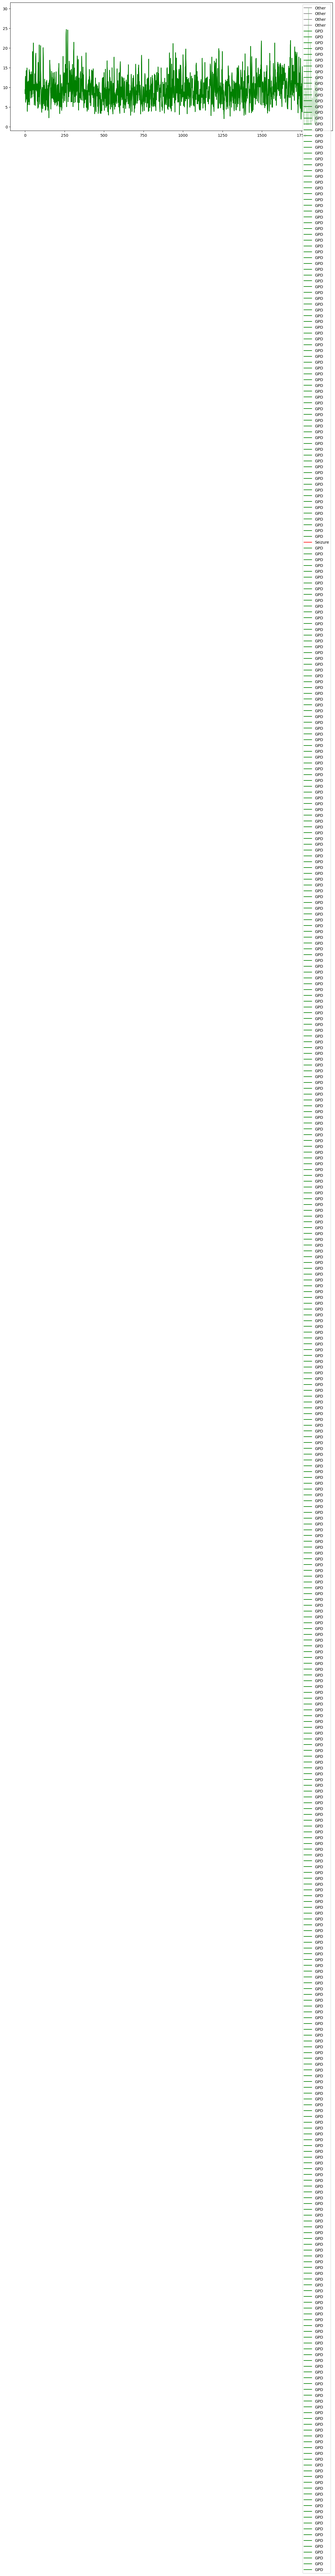

In [56]:
spc_id = train["spectrogram_id"][800]
train_spc = train.loc[train["spectrogram_id"] == spc_id].reset_index()
spc_full = open_file_id(Dir.spc_train, spc_id)
SPC_SIGNAL_NAMES = spc_full.columns

fig, ax = plt.subplots(figsize=(15,6))

for i in range(len(train_spc)):
    offset = int(train_spc.loc[i, "eeg_label_offset_seconds"])
    cls = train_spc.loc[i, "expert_consensus"]
    length = int(train_spc.loc[i, "eeg_length"])
    if length > 0 :
        start, end = offset * 200, offset * 200 + length * 200
        spc = get_eeg_subsample(spc_full, start, end)
        spc[spc.columns[4]].plot(ax=ax, c=COLOR_MAP[cls], label=str(cls))

ax.legend()